# Mencari Jarak Suara Menggunakan DTW

## Dynamic Time Warping (DTW)

Dynamic Time Warping (DTW) merupakan teknik untuk mengukur tingkat kesamaan antara dua deret waktu yang kemungkinan memiliki durasi berbeda. Dalam konteks pengenalan suara, DTW berperan dalam mencocokkan pola akustik dari dua sinyal suara meskipun kecepatan atau panjang pengucapannya tidak sama.

DTW beroperasi dengan mencari lintasan penyesuaian (warping path) yang paling optimal di antara dua rangkaian fitur, contohnya fitur MFCC dari sampel audio dan audio input baru. Lintasan ini dipilih agar total jarak (biaya) antara kedua rangkaian menjadi minimum.

## Inti Kerja DTW

1. **Perhitungan Jarak Lokal** - Menghitung jarak antara setiap pasangan elemen fitur dari dua sinyal
2. **Penyusunan Matriks Biaya Kumulatif** - Membangun matriks menggunakan pemrograman dinamis
3. **Pencarian Jalur Optimal** - Menemukan lintasan melalui matriks yang meminimalkan total biaya
4. **Pengambilan Nilai Akhir** - Menggunakan nilai akhir sebagai jarak DTW

Semakin rendah nilai DTW yang diperoleh, semakin tinggi kemiripan antara kedua pola suara tersebut.


## Suara Buka

In [34]:
import os
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [35]:
DATASET_PATH = "gabunganaudio" 
train_path = os.path.join(DATASET_PATH, "train")

### Visualisasi Suara Waveforms

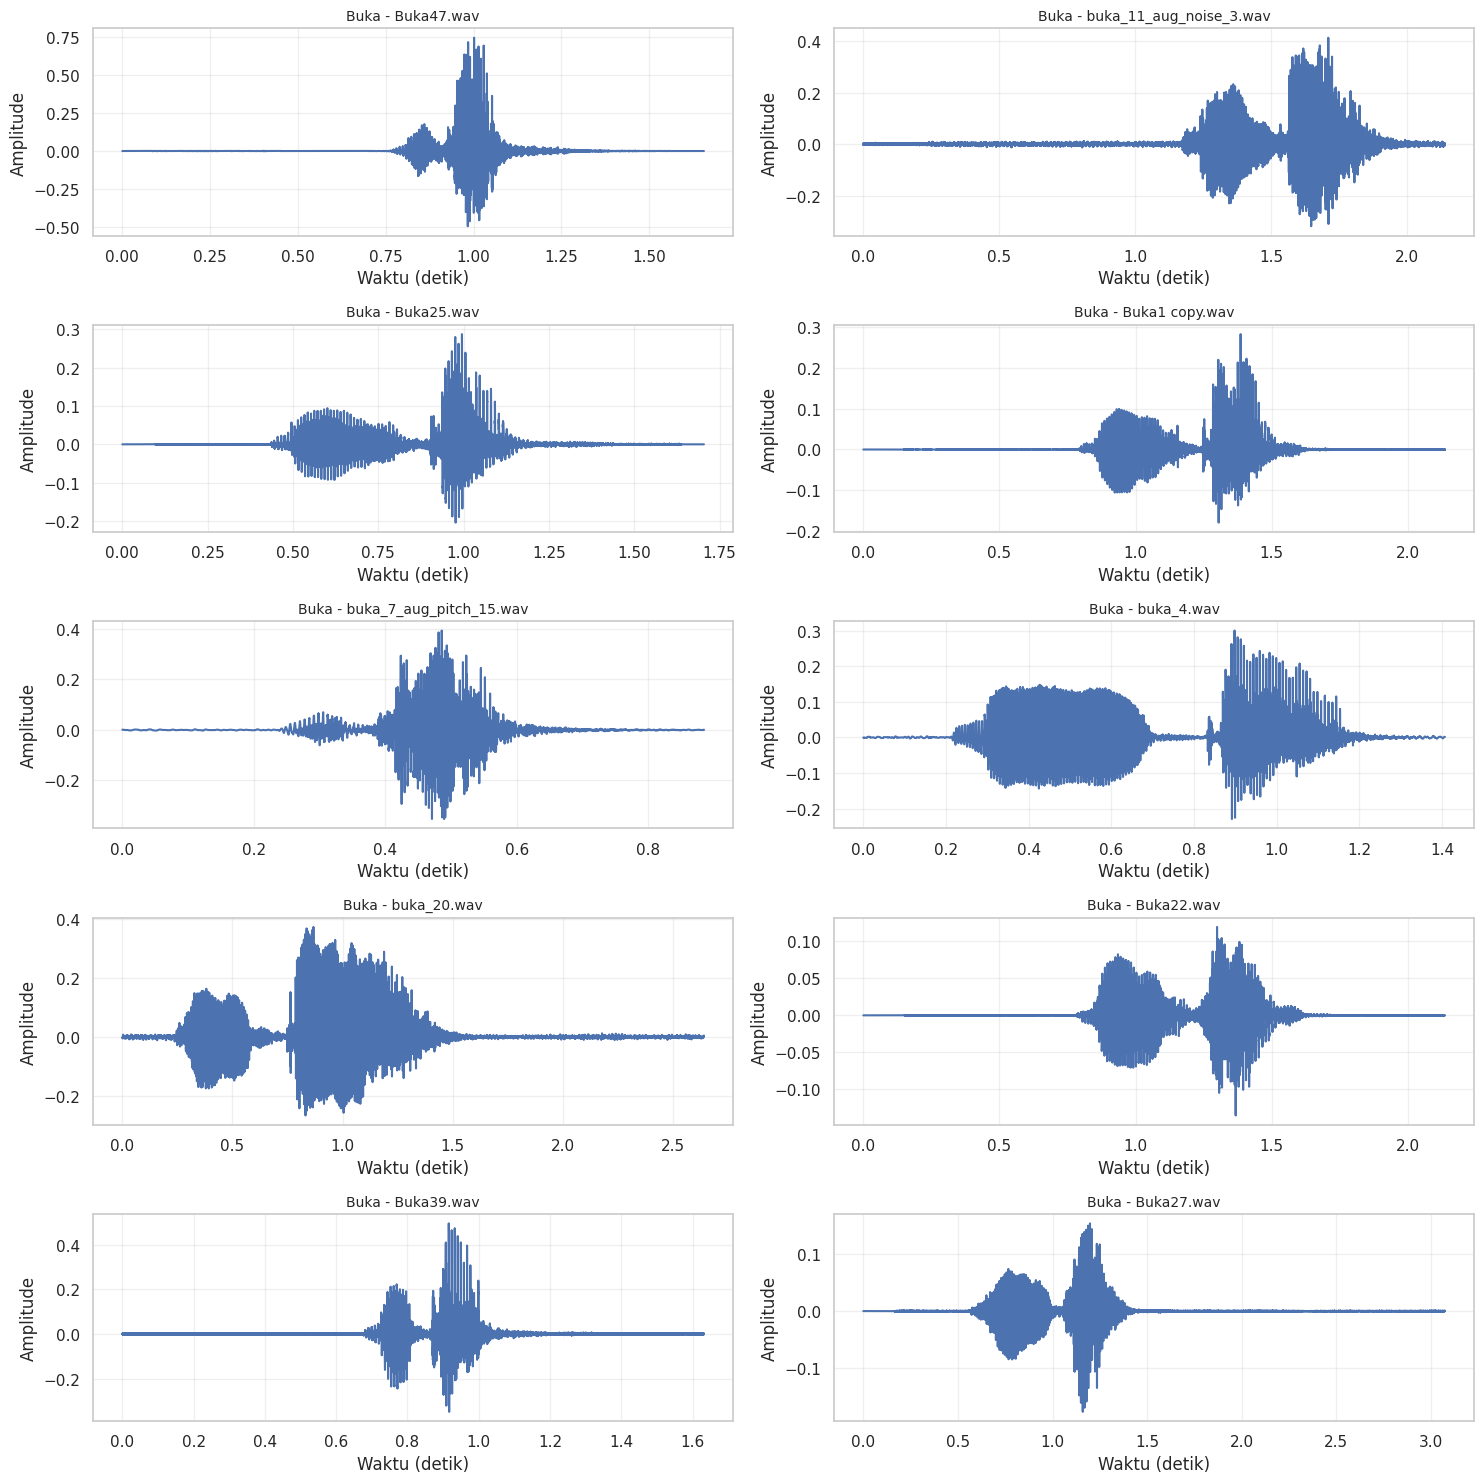

Menampilkan 10 file audio 'buka'


In [36]:
def plot_all_tutup_timeseries(base_path, max_files=None):
    tutup_path = os.path.join(base_path, "buka")
    tutup_files = os.listdir(tutup_path)
    
    if max_files:
        tutup_files = tutup_files[:max_files]
    
    n_files = len(tutup_files)
    

    cols = 2
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, filename in enumerate(tutup_files):
        file_path = os.path.join(tutup_path, filename)
        
        # Load audio
        y, sr = librosa.load(file_path, sr=None)
        
        # Hitung time axis
        time = np.linspace(0, len(y)/sr, len(y))
        
        # Plot
        row = i // cols
        col = i % cols
        
        axes[row, col].plot(time, y)
        axes[row, col].set_title(f'Buka - {filename}', fontsize=10)
        axes[row, col].set_xlabel('Waktu (detik)')
        axes[row, col].set_ylabel('Amplitude')
        axes[row, col].grid(True, alpha=0.3)
    
    for i in range(len(tutup_files), rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Menampilkan {len(tutup_files)} file audio 'buka'")

plot_all_tutup_timeseries(train_path, max_files=10)

### Perhitungan Dynamic Time Warping

In [37]:
import numpy as np
from dtaidistance import dtw
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# def extract_features_for_dtw(audio_path, feature_type='mfcc'):
#     y, sr = librosa.load(audio_path, sr=22050)
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#     chroma = librosa.feature.chroma_stft(y=y, sr=sr)

#     mel_6_mean = np.mean(mel_spec_db[6, :])  
#     mel_6_std = np.std(mel_spec_db[6, :])    
#     mel_7_mean = np.mean(mel_spec_db[7, :])   
#     mel_7_std = np.std(mel_spec_db[7, :])    
#     chroma_0_mean = np.mean(chroma[0, :])    
    
#     from scipy.stats import skew
#     stat_skew = skew(y)
    
#     model_features = np.array([
#         mel_7_std,      
#         chroma_0_mean,
#         mel_6_std,      
#         stat_skew,      
#         mel_7_mean 
#     ])
    
#     return model_features

def extract_features_for_dtw(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    seq = mfcc[0, :]
    
    return seq



def calculate_dtw_distances(new_audio_path, train_path, max_files=100):
    try:
        # new_features = extract_features_for_dtw(new_audio_path, 'mfcc')
        new_features = extract_features_for_dtw(new_audio_path)
    except Exception as e:
        print(f"Errorrrrrrr")
        return None
    
    tutup_train_files = []
    train_labels = []
    
    tutup_path = os.path.join(train_path, "buka")
    if os.path.exists(tutup_path):
        for file in os.listdir(tutup_path):
            if file.endswith(('.wav')):
                tutup_train_files.append(os.path.join(tutup_path, file))
                train_labels.append('buka')
    
    if len(tutup_train_files) > max_files:
        indices = np.random.choice(len(tutup_train_files), max_files, replace=False)
        tutup_train_files = [tutup_train_files[i] for i in indices]
        train_labels = [train_labels[i] for i in indices]
    
    results = []
    
    for i, (train_file, label) in enumerate(zip(tutup_train_files, train_labels)):
        try:
            # Ekstrak fitur dari file training
            # train_features = extract_features_for_dtw(train_file, 'mfcc')
            train_features = extract_features_for_dtw(train_file)
            
            # Hitung jarak DTW
            dtw_distance = dtw.distance(new_features, train_features)
            
            results.append({
                'rank': i + 1,
                'filename': os.path.basename(train_file),
                'label': label,
                'dtw_distance': dtw_distance,
                'file_path': train_file
            })
            
                
        except Exception as e:
            print(f"  Error processing {train_file}: {e}")
            continue
    
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('dtw_distance').reset_index(drop=True)
    df_results['rank'] = range(1, len(df_results) + 1)
    
    return df_results

# Path audio baru
new_audio_path = "gabunganaudio/train/bukanew.wav"

# Hitung jarak DTW
dtw_results = calculate_dtw_distances(new_audio_path, train_path, max_files=100)

if dtw_results is not None:
    print(f"\n=== RANKING JARAK DTW (Top 20) ===")
    print(dtw_results.head(20).to_string(index=False))
    
    print(f"\n=== STATISTIK HASIL ===")
    print(f"Total file dianalisis: {len(dtw_results)}")
    print(f"Jarak minimum: {dtw_results['dtw_distance'].min():.4f}")
    print(f"Jarak maksimum: {dtw_results['dtw_distance'].max():.4f}")
    print(f"Jarak rata-rata: {dtw_results['dtw_distance'].mean():.4f}")
    


=== RANKING JARAK DTW (Top 20) ===
 rank                 filename label  dtw_distance                                         file_path
    1 buka_11_aug_shift_23.wav  buka    382.517769 gabunganaudio/train/buka/buka_11_aug_shift_23.wav
    2  buka_11_aug_noise_3.wav  buka    392.582834  gabunganaudio/train/buka/buka_11_aug_noise_3.wav
    3              buka_11.wav  buka    447.051853              gabunganaudio/train/buka/buka_11.wav
    4  buka_2_aug_noise_28.wav  buka    466.331410  gabunganaudio/train/buka/buka_2_aug_noise_28.wav
    5               Buka37.wav  buka    483.874080               gabunganaudio/train/buka/Buka37.wav
    6              buka_18.wav  buka    499.659337              gabunganaudio/train/buka/buka_18.wav
    7 buka_18_aug_noise_14.wav  buka    499.782593 gabunganaudio/train/buka/buka_18_aug_noise_14.wav
    8              buka_12.wav  buka    510.688230              gabunganaudio/train/buka/buka_12.wav
    9              buka_19.wav  buka    519.059877     

### Perangkingan dan Perbandingan

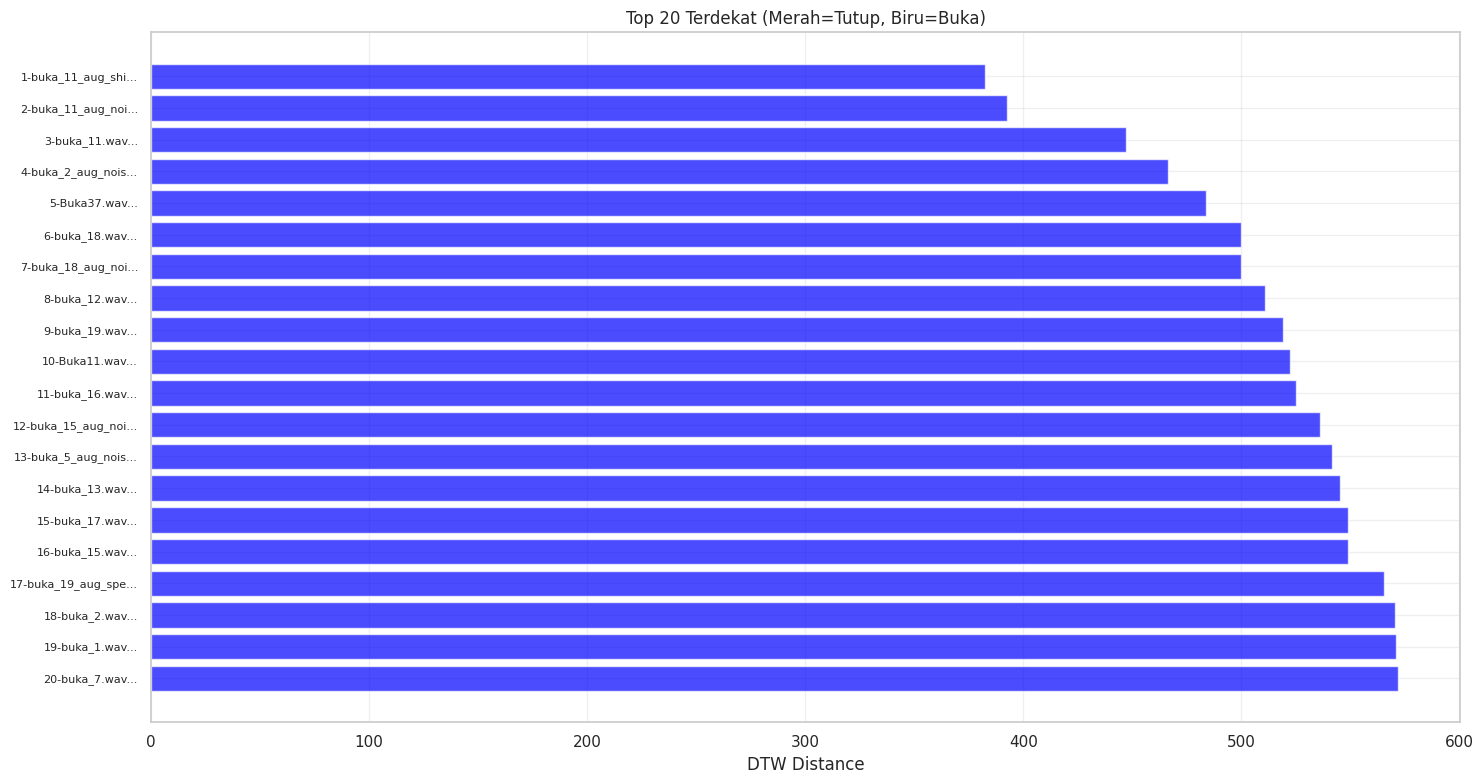


=== PERBANDINGAN WAVEFORM ===


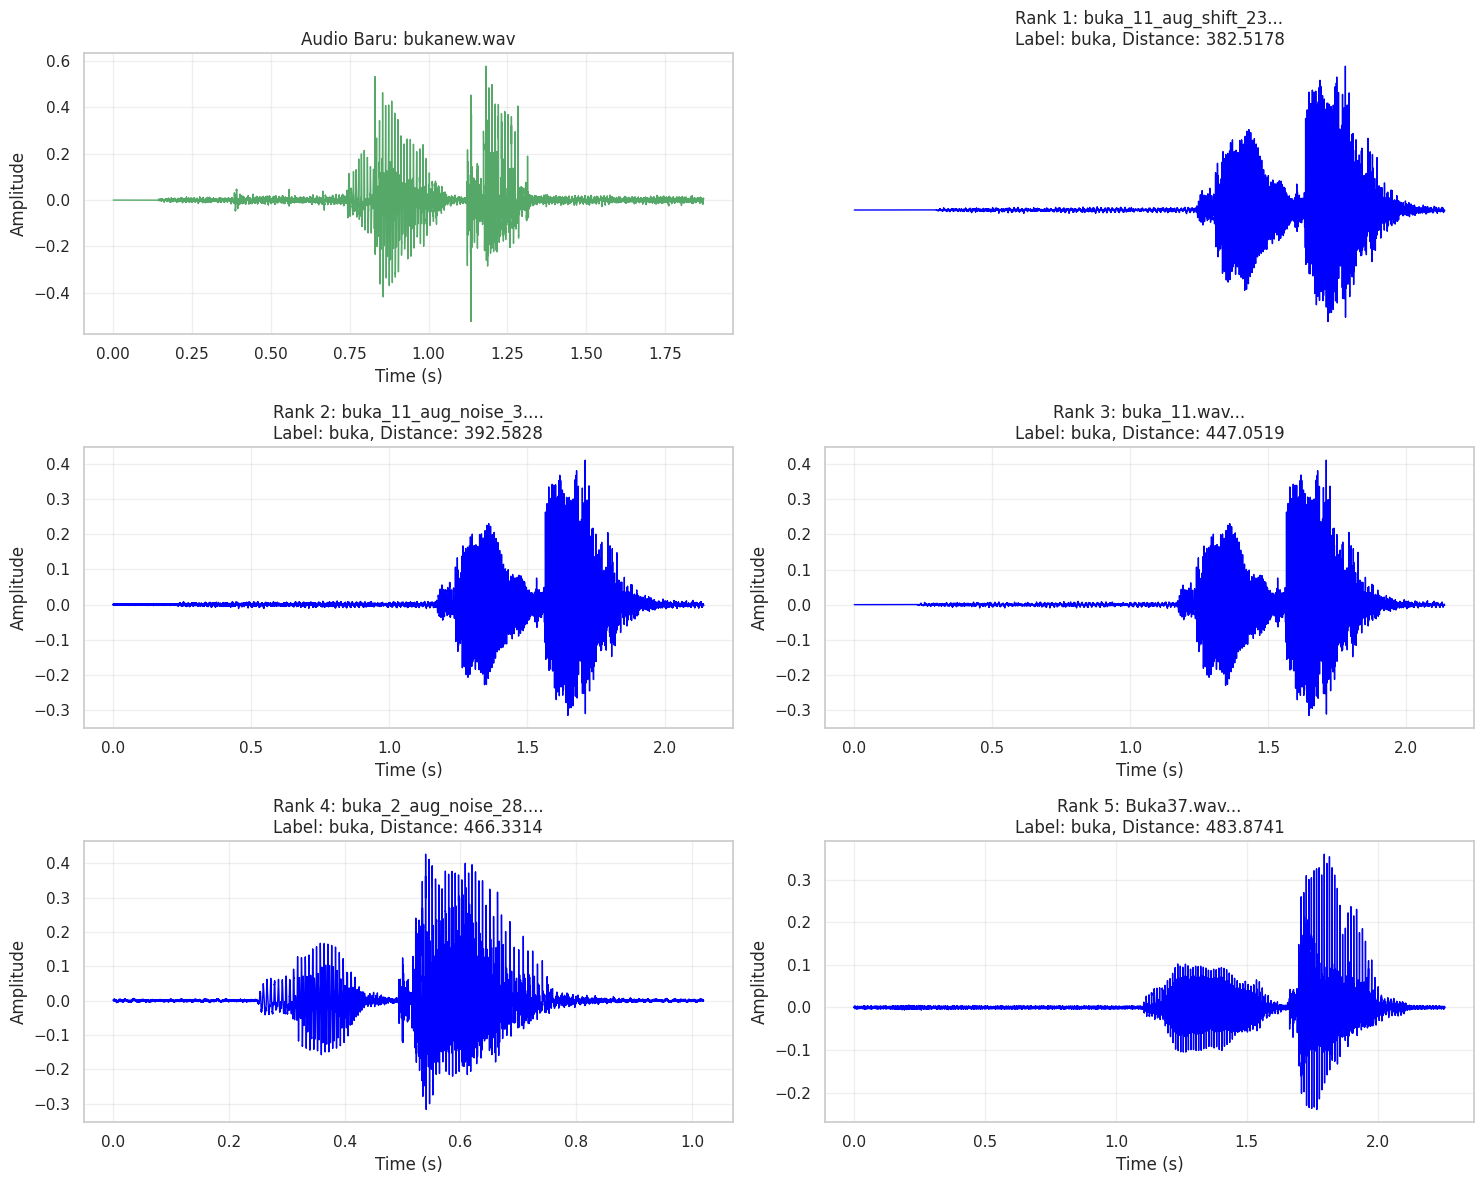


=== SEMUA RANKING DTW (1-100) ===
 rank                 filename label  dtw_distance
    1 buka_11_aug_shift_23.wav  buka    382.517769
    2  buka_11_aug_noise_3.wav  buka    392.582834
    3              buka_11.wav  buka    447.051853
    4  buka_2_aug_noise_28.wav  buka    466.331410
    5               Buka37.wav  buka    483.874080
    6              buka_18.wav  buka    499.659337
    7 buka_18_aug_noise_14.wav  buka    499.782593
    8              buka_12.wav  buka    510.688230
    9              buka_19.wav  buka    519.059877
   10               Buka11.wav  buka    522.181213
   11              buka_16.wav  buka    525.251487
   12 buka_15_aug_noise_24.wav  buka    535.851309
   13   buka_5_aug_noise_9.wav  buka    541.601878
   14              buka_13.wav  buka    545.225011
   15              buka_17.wav  buka    548.849905
   16              buka_15.wav  buka    549.044824
   17  buka_19_aug_speed_7.wav  buka    565.323110
   18               buka_2.wav  buka    570.292

In [38]:
def visualize_dtw_results(dtw_results, new_audio_path):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    # Top 20 ranking
    top_20 = dtw_results.head(20)
    colors = ['red' if label == 'tutup' else 'blue' for label in top_20['label']]
    
    ax.barh(range(len(top_20)), top_20['dtw_distance'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels([f"{row['rank']}-{row['filename'][:15]}..." 
                        for _, row in top_20.iterrows()], fontsize=8)
    ax.set_xlabel('DTW Distance')
    ax.set_title('Top 20 Terdekat (Merah=Tutup, Biru=Buka)')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Waveform comparison
    print("\n=== PERBANDINGAN WAVEFORM ===")
    plot_waveform_comparison(new_audio_path, dtw_results.head(5))

def plot_waveform_comparison(new_audio_path, top_matches):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Audio baru
    y_new, sr_new = librosa.load(new_audio_path, sr=22050)
    time_new = np.linspace(0, len(y_new)/sr_new, len(y_new))
    
    axes[0, 0].plot(time_new, y_new, 'g-', linewidth=1)
    axes[0, 0].set_title(f'Audio Baru: {os.path.basename(new_audio_path)}')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    for i, (_, row) in enumerate(top_matches.iterrows()):
        if i >= 5:
            break
            
        try:
            y_match, sr_match = librosa.load(row['file_path'], sr=22050)
            time_match = np.linspace(0, len(y_match)/sr_match, len(y_match))
            
            row_idx = (i + 1) // 2
            col_idx = (i + 1) % 2
            
            if row_idx < 3:
                color = 'red' if row['label'] == 'tutup' else 'blue'
                axes[row_idx, col_idx].plot(time_match, y_match, color=color, linewidth=1)
                axes[row_idx, col_idx].set_title(f'Rank {row["rank"]}: {row["filename"][:20]}...\nLabel: {row["label"]}, Distance: {row["dtw_distance"]:.4f}')
                axes[row_idx, col_idx].set_xlabel('Time (s)')
                axes[row_idx, col_idx].set_ylabel('Amplitude')
                axes[row_idx, col_idx].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error loading {row['filename']}: {e}")
            continue
    
    axes[0, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if dtw_results is not None:
    visualize_dtw_results(dtw_results, new_audio_path)
    
    print(f"\n=== SEMUA RANKING DTW (1-{len(dtw_results)}) ===")
    print(dtw_results[['rank', 'filename', 'label', 'dtw_distance']].to_string(index=False))

## Suara Tutup

In [39]:
import os
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [40]:
DATASET_PATH = "gabunganaudio" 
train_path = os.path.join(DATASET_PATH, "train")

### Visualisasi Suara Waveforms

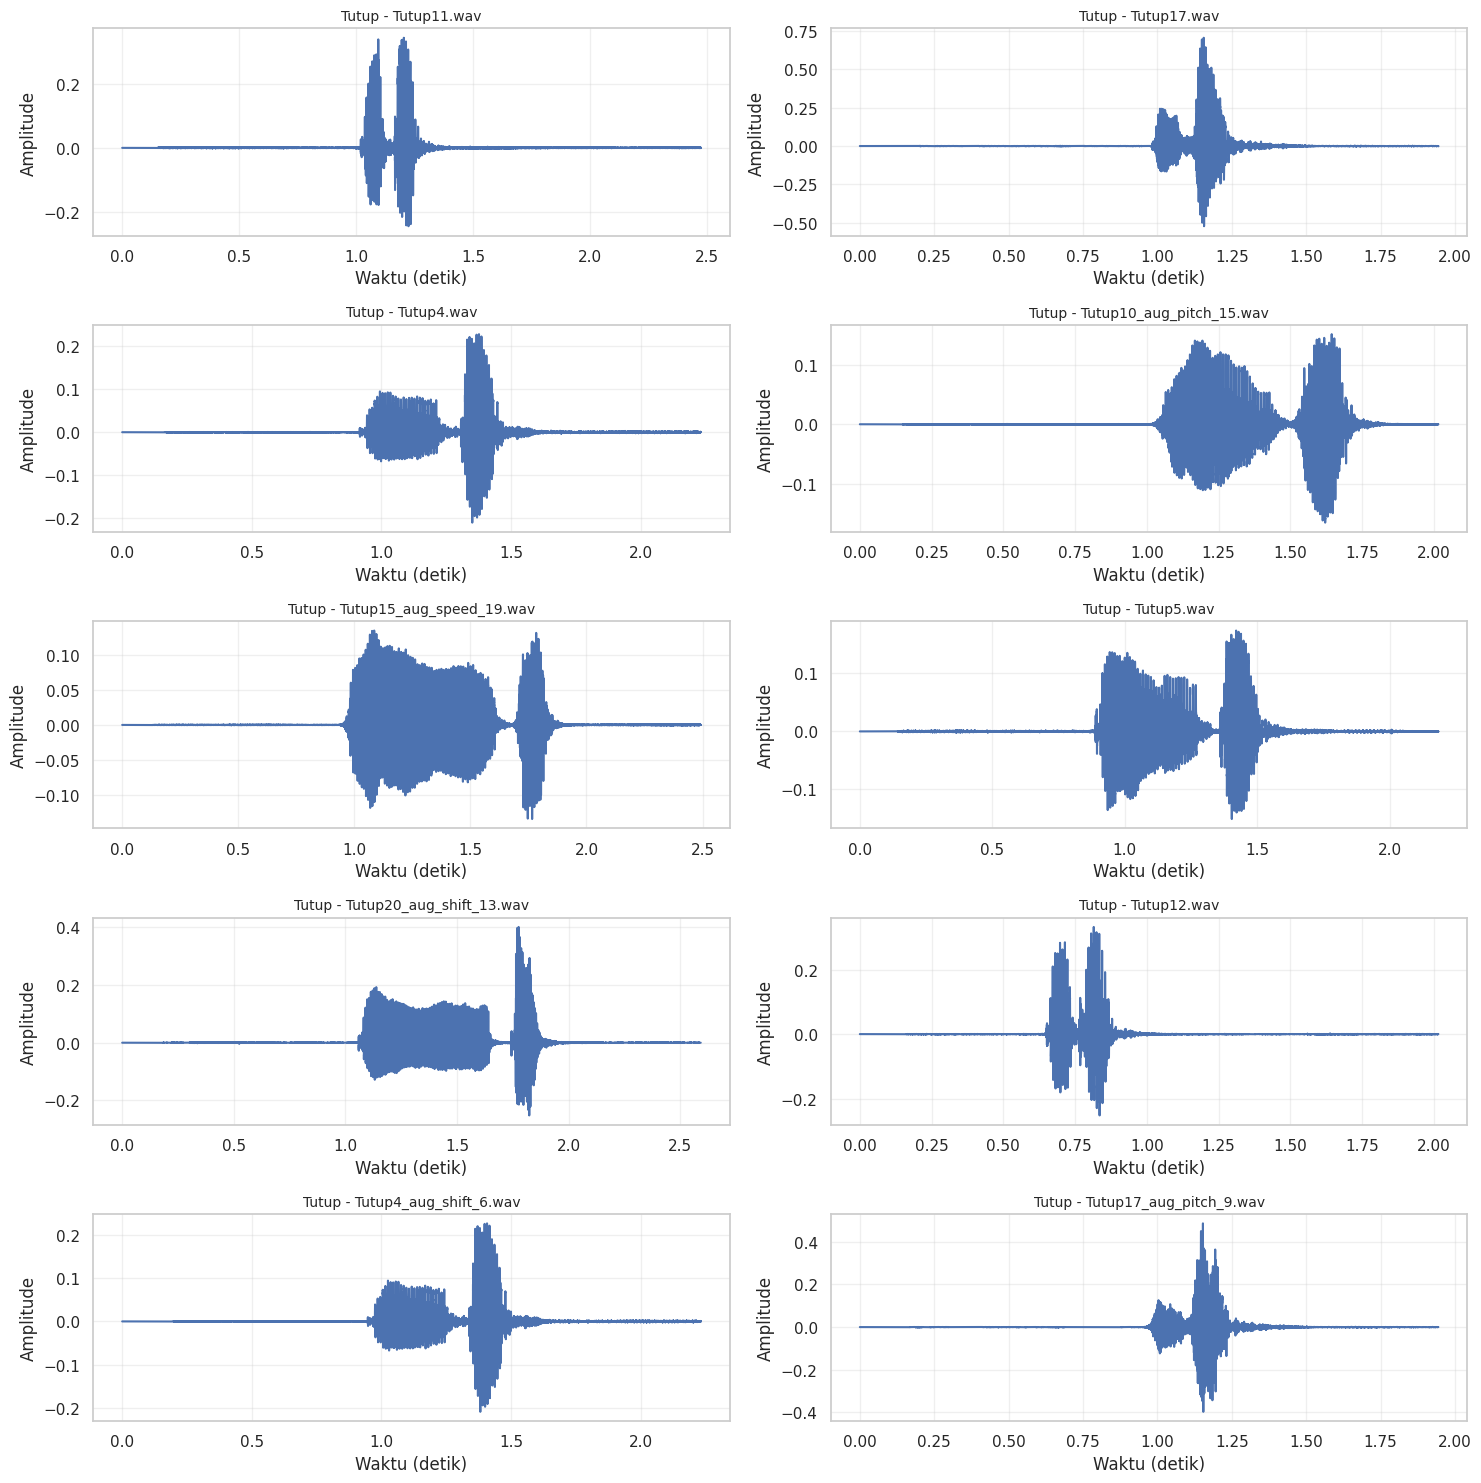

Menampilkan 10 file audio 'tutup'


In [41]:
def plot_all_tutup_timeseries(base_path, max_files=None):
    tutup_path = os.path.join(base_path, "tutup")
    tutup_files = os.listdir(tutup_path)
    
    if max_files:
        tutup_files = tutup_files[:max_files]
    
    n_files = len(tutup_files)
    

    cols = 2
    rows = (n_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, filename in enumerate(tutup_files):
        file_path = os.path.join(tutup_path, filename)
        
        # Load audio
        y, sr = librosa.load(file_path, sr=None)
        
        # Hitung time axis
        time = np.linspace(0, len(y)/sr, len(y))
        
        # Plot
        row = i // cols
        col = i % cols
        
        axes[row, col].plot(time, y)
        axes[row, col].set_title(f'Tutup - {filename}', fontsize=10)
        axes[row, col].set_xlabel('Waktu (detik)')
        axes[row, col].set_ylabel('Amplitude')
        axes[row, col].grid(True, alpha=0.3)
    
    for i in range(len(tutup_files), rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Menampilkan {len(tutup_files)} file audio 'tutup'")

plot_all_tutup_timeseries(train_path, max_files=10)

### Perhitungan Dynamic Time Warping

In [42]:
import numpy as np
from dtaidistance import dtw
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# def extract_features_for_dtw(audio_path, feature_type='mfcc'):
#     y, sr = librosa.load(audio_path, sr=22050)
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
#     chroma = librosa.feature.chroma_stft(y=y, sr=sr)

#     mel_6_mean = np.mean(mel_spec_db[6, :])  
#     mel_6_std = np.std(mel_spec_db[6, :])    
#     mel_7_mean = np.mean(mel_spec_db[7, :])   
#     mel_7_std = np.std(mel_spec_db[7, :])    
#     chroma_0_mean = np.mean(chroma[0, :])    
    
#     from scipy.stats import skew
#     stat_skew = skew(y)
    
#     model_features = np.array([
#         mel_7_std,      
#         chroma_0_mean,
#         mel_6_std,      
#         stat_skew,      
#         mel_7_mean 
#     ])
    
#     return model_features

def extract_features_for_dtw(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    seq = mfcc[0, :]
    
    return seq



def calculate_dtw_distances(new_audio_path, train_path, max_files=100):
    try:
        # new_features = extract_features_for_dtw(new_audio_path, 'mfcc')
        new_features = extract_features_for_dtw(new_audio_path)
    except Exception as e:
        print(f"Errorrrrrrr")
        return None
    
    tutup_train_files = []
    train_labels = []
    
    tutup_path = os.path.join(train_path, "tutup")
    if os.path.exists(tutup_path):
        for file in os.listdir(tutup_path):
            if file.endswith(('.wav')):
                tutup_train_files.append(os.path.join(tutup_path, file))
                train_labels.append('tutup')
    
    if len(tutup_train_files) > max_files:
        indices = np.random.choice(len(tutup_train_files), max_files, replace=False)
        tutup_train_files = [tutup_train_files[i] for i in indices]
        train_labels = [train_labels[i] for i in indices]
    
    results = []
    
    for i, (train_file, label) in enumerate(zip(tutup_train_files, train_labels)):
        try:
            # Ekstrak fitur dari file training
            # train_features = extract_features_for_dtw(train_file, 'mfcc')
            train_features = extract_features_for_dtw(train_file)
            
            # Hitung jarak DTW
            dtw_distance = dtw.distance(new_features, train_features)
            
            results.append({
                'rank': i + 1,
                'filename': os.path.basename(train_file),
                'label': label,
                'dtw_distance': dtw_distance,
                'file_path': train_file
            })
            
                
        except Exception as e:
            print(f"  Error processing {train_file}: {e}")
            continue
    
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('dtw_distance').reset_index(drop=True)
    df_results['rank'] = range(1, len(df_results) + 1)
    
    return df_results

# Path audio baru
new_audio_path = "gabunganaudio/train/tutupnew.wav"

# Hitung jarak DTW
dtw_results = calculate_dtw_distances(new_audio_path, train_path, max_files=100)

if dtw_results is not None:
    print(f"\n=== RANKING JARAK DTW (Top 20) ===")
    print(dtw_results.head(20).to_string(index=False))
    
    print(f"\n=== STATISTIK HASIL ===")
    print(f"Total file dianalisis: {len(dtw_results)}")
    print(f"Jarak minimum: {dtw_results['dtw_distance'].min():.4f}")
    print(f"Jarak maksimum: {dtw_results['dtw_distance'].max():.4f}")
    print(f"Jarak rata-rata: {dtw_results['dtw_distance'].mean():.4f}")
    


=== RANKING JARAK DTW (Top 20) ===
 rank                 filename label  dtw_distance                                          file_path
    1              Tutup20.wav tutup      0.000000              gabunganaudio/train/tutup/Tutup20.wav
    2 Tutup20_aug_shift_13.wav tutup     30.815539 gabunganaudio/train/tutup/Tutup20_aug_shift_13.wav
    3 Tutup20_aug_shift_10.wav tutup    106.067127 gabunganaudio/train/tutup/Tutup20_aug_shift_10.wav
    4              Tutup10.wav tutup    187.487968              gabunganaudio/train/tutup/Tutup10.wav
    5  Tutup7_aug_noise_29.wav tutup    192.054720  gabunganaudio/train/tutup/Tutup7_aug_noise_29.wav
    6               Tutup6.wav tutup    192.945325               gabunganaudio/train/tutup/Tutup6.wav
    7  Tutup9_aug_noise_26.wav tutup    219.962346  gabunganaudio/train/tutup/Tutup9_aug_noise_26.wav
    8              Tutup19.wav tutup    232.378244              gabunganaudio/train/tutup/Tutup19.wav
    9              Tutup16.wav tutup    234.21

### Perangkingan dan Perbandingan

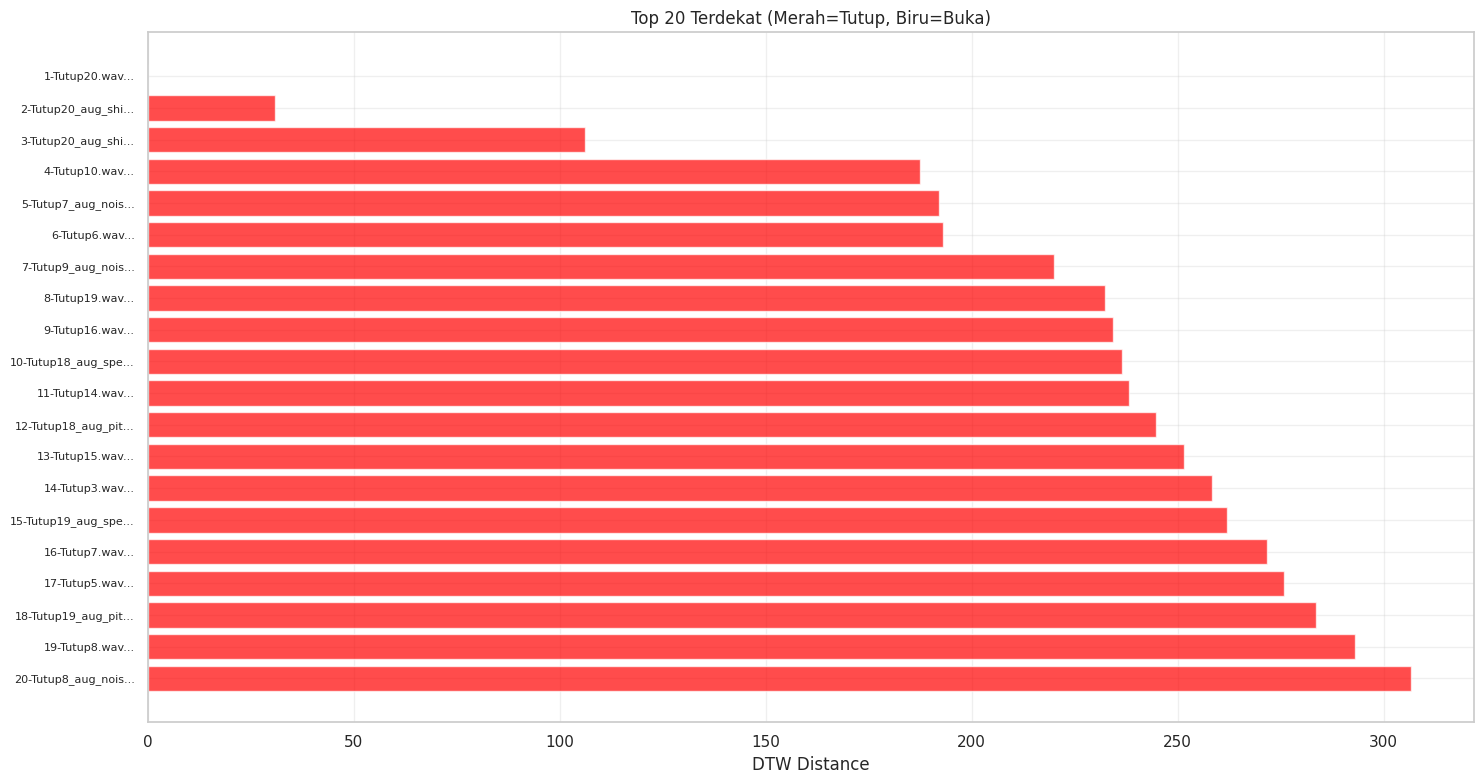


=== PERBANDINGAN WAVEFORM ===


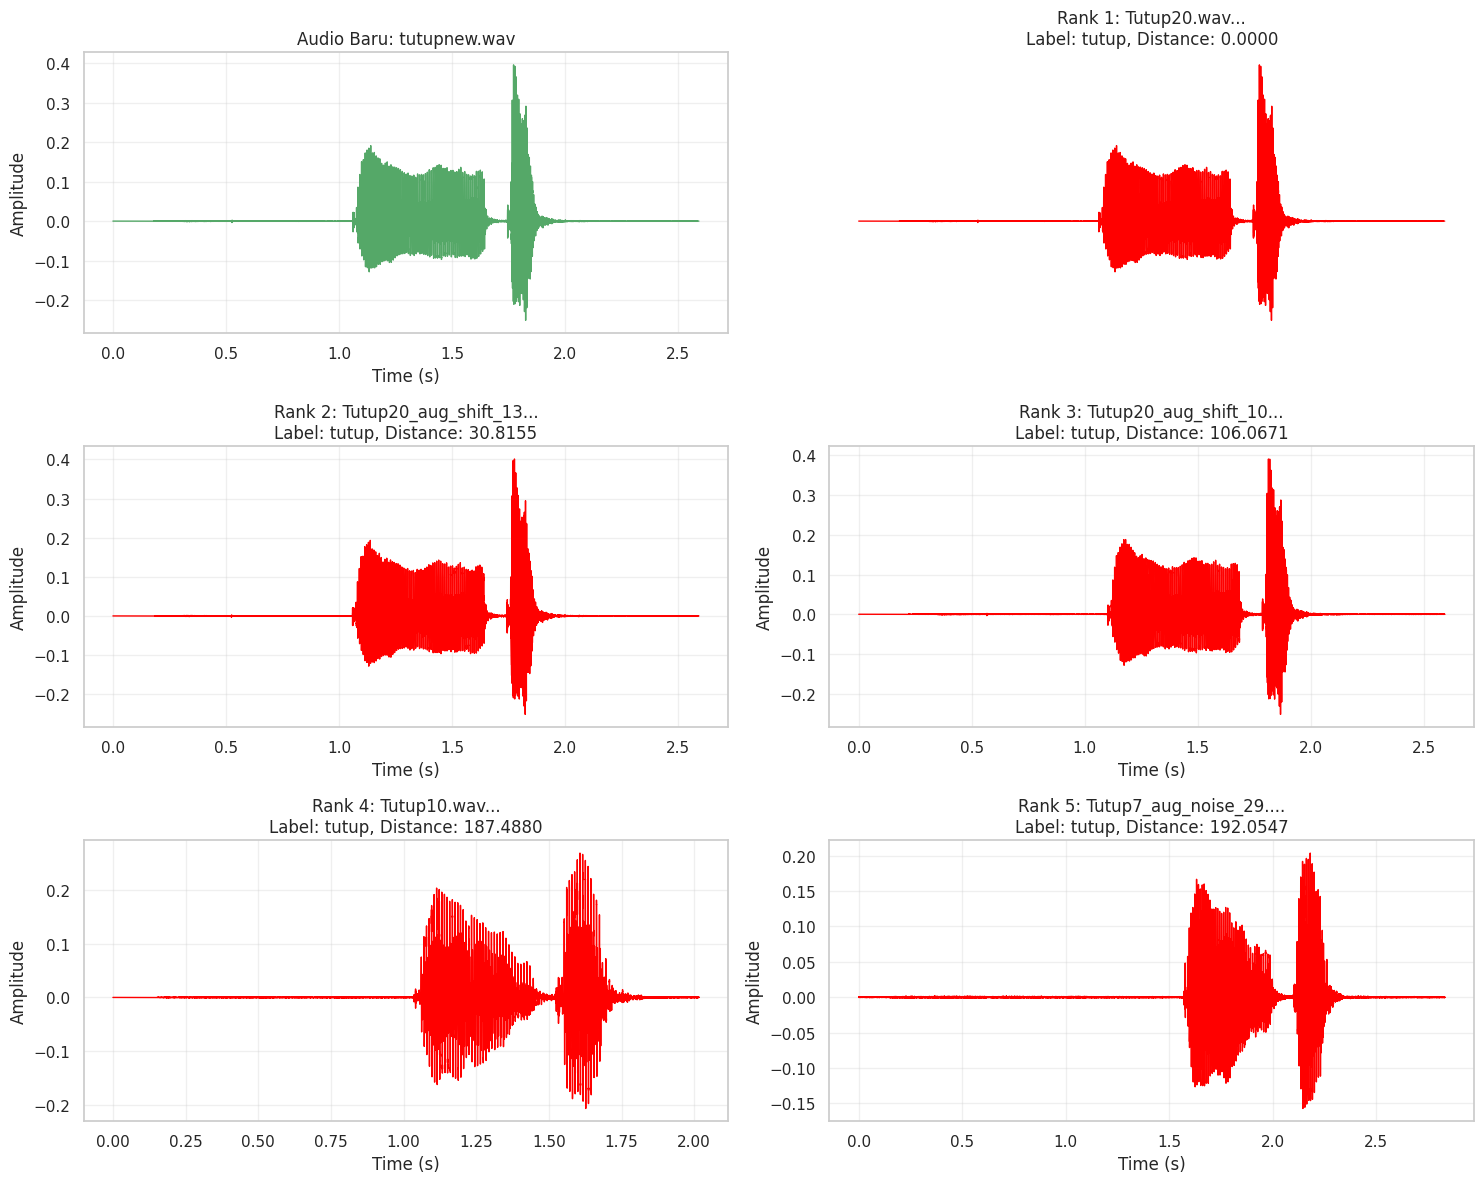


=== SEMUA RANKING DTW (1-50) ===
 rank                 filename label  dtw_distance
    1              Tutup20.wav tutup      0.000000
    2 Tutup20_aug_shift_13.wav tutup     30.815539
    3 Tutup20_aug_shift_10.wav tutup    106.067127
    4              Tutup10.wav tutup    187.487968
    5  Tutup7_aug_noise_29.wav tutup    192.054720
    6               Tutup6.wav tutup    192.945325
    7  Tutup9_aug_noise_26.wav tutup    219.962346
    8              Tutup19.wav tutup    232.378244
    9              Tutup16.wav tutup    234.219749
   10 Tutup18_aug_speed_11.wav tutup    236.572515
   11              Tutup14.wav tutup    238.276576
   12  Tutup18_aug_pitch_1.wav tutup    244.708348
   13              Tutup15.wav tutup    251.552345
   14               Tutup3.wav tutup    258.211003
   15 Tutup19_aug_speed_22.wav tutup    261.896002
   16               Tutup7.wav tutup    271.630839
   17               Tutup5.wav tutup    275.792622
   18  Tutup19_aug_pitch_4.wav tutup    283.4936

In [46]:
def visualize_dtw_results(dtw_results, new_audio_path):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    # Top 20 ranking
    top_20 = dtw_results.head(20)
    colors = ['red' if label == 'tutup' else 'blue' for label in top_20['label']]
    
    ax.barh(range(len(top_20)), top_20['dtw_distance'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_20)))
    ax.set_yticklabels([f"{row['rank']}-{row['filename'][:15]}..." 
                        for _, row in top_20.iterrows()], fontsize=8)
    ax.set_xlabel('DTW Distance')
    ax.set_title('Top 20 Terdekat (Merah=Tutup, Biru=Buka)')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== PERBANDINGAN WAVEFORM ===")
    plot_waveform_comparison(new_audio_path, dtw_results.head(5))

def plot_waveform_comparison(new_audio_path, top_matches):
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Audio baru
    y_new, sr_new = librosa.load(new_audio_path, sr=22050)
    time_new = np.linspace(0, len(y_new)/sr_new, len(y_new))
    
    axes[0, 0].plot(time_new, y_new, 'g-', linewidth=1)
    axes[0, 0].set_title(f'Audio Baru: {os.path.basename(new_audio_path)}')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    for i, (_, row) in enumerate(top_matches.iterrows()):
        if i >= 5:
            break
            
        try:
            y_match, sr_match = librosa.load(row['file_path'], sr=22050)
            time_match = np.linspace(0, len(y_match)/sr_match, len(y_match))
            
            row_idx = (i + 1) // 2
            col_idx = (i + 1) % 2
            
            if row_idx < 3:
                color = 'red' if row['label'] == 'tutup' else 'blue'
                axes[row_idx, col_idx].plot(time_match, y_match, color=color, linewidth=1)
                axes[row_idx, col_idx].set_title(f'Rank {row["rank"]}: {row["filename"][:20]}...\nLabel: {row["label"]}, Distance: {row["dtw_distance"]:.4f}')
                axes[row_idx, col_idx].set_xlabel('Time (s)')
                axes[row_idx, col_idx].set_ylabel('Amplitude')
                axes[row_idx, col_idx].grid(True, alpha=0.3)
        except Exception as e:
            print(f"Error loading {row['filename']}: {e}")
            continue
    
    axes[0, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

if dtw_results is not None:
    visualize_dtw_results(dtw_results, new_audio_path)
    
    print(f"\n=== SEMUA RANKING DTW (1-{len(dtw_results)}) ===")
    print(dtw_results[['rank', 'filename', 'label', 'dtw_distance']].to_string(index=False))